<h1><u>Building an Expected Goals Model</u></h1>

<i>Data used is Statsbomb open data from github @ https://raw.githubusercontent.com/statsbomb/open-data/ that they've made avaialable for free to the public. I'm specifically using event data from matches from the 2018 World Cup to build this model. This is a smaller scale model that may be less fitted and less accurate but is nonetheless a proof of concept and stepping stone for larger and later projects I plan on tackling.</i>

<u>Libraries, Data Source, and Functions</u>

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

model = LogisticRegression()

In [3]:
def parseData(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]
    
    all_events = []
    
    for match_id in match_ids:
        
        events = requests.get(url=match_url.format(match_id)).json()
        shots = [x for x in events if x['type']['name'] == "Shot"]
        
        for s in shots:
            attributes = {
                "x": s['location'][0],
                "y": s['location'][1],
                "head": 1 if s['shot']['body_part']['name'] == "Head" else 0,
                "phase": s['shot']['type']['name'],
                "tech": 1 if s['shot']['technique']['name'] == "Normal" else 0,
                "outcome": 1 if s['shot']['outcome']['name'] == "Goal" else 0,
                "statsbomb_xg": s['shot']['statsbomb_xg']
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)


def distance_to_goal(origin):
    dest = np.array([120., 40.])
    return np.sqrt(np.sum((origin - dest) ** 2))


def goal_angle(origin):
    p0 = np.array((120., 36.)) ##Left Post
    p1 = np.array(origin, dtype = np.float)
    p2 = np.array((120., 44.)) ##Right Post
    
    v0 = p0 - p1
    v1 = p2 - p1
    
    angle = np.abs(np.math.atan2(np.linalg.det([v0,v1]), np.dot(v0, v1)))
    
    return angle

<u>Data Ingestion & Pre-Processing</u>

In [4]:
competition_id = 43
season_id = 3
##These values are set to pull World Cup 2018 data from github

df = parseData(competition_id, season_id)

In [5]:
df['distance_to_goal'] = df.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis = 1)
df['goal_angle'] = df.apply(lambda r: goal_angle(r[['x', 'y']]), axis = 1)

In [6]:
##We don't want to include free kicks or penalties in the model since they are distinct events in different phases of play that may be more or less predictable
shots = df[~df['phase'].isin(['Free Kick', 'Penalty'])]

In [7]:
shots.head(10)

,x,y,head,phase,tech,outcome,statsbomb_xg,distance_to_goal,goal_angle
0,97.0,32.0,0,Open Play,1,0,0.037902,24.351591,0.308696
1,108.0,51.0,0,Open Play,0,0,0.044519,16.278821,0.367981
2,109.0,55.0,0,Open Play,1,0,0.040015,18.601075,0.260602
3,102.0,23.0,0,Open Play,1,0,0.026998,24.758837,0.236685
4,114.0,48.0,1,Open Play,1,0,0.040895,10.000000,0.519146
5,116.0,35.0,0,Open Play,1,0,0.272925,6.403124,0.907593
6,100.0,51.0,0,Open Play,1,0,0.027069,22.825424,0.306826
7,83.0,53.0,0,Open Play,1,0,0.011727,39.217343,0.192083
9,105.0,48.0,0,Open Play,0,0,0.053922,17.000000,0.414139
10,88.0,37.0,0,Open Play,1,0,0.016155,32.140317,0.246598


In [8]:
shots.shape

(1556, 9)

In [9]:
X = shots[['distance_to_goal', 'goal_angle', 'tech', 'head']]
y = shots['outcome']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100, stratify = y)

In [11]:
print('Original dataset' + ': ' + str(len(y)))
print('Training Set' + ': ' + str(len(y_train)))
print('Test Set'  + ': '+ str(len(y_test)))

Original dataset: 1556
Training Set: 1089
Test Set: 467


<u>Modelling and Visualizations</u>

0    1427
1     129
Name: outcome, dtype: int64


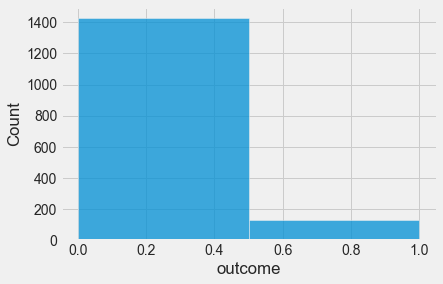

In [12]:
sns.histplot(shots['outcome'], stat = 'count', bins = 2)
print(shots['outcome'].value_counts())

<i>It's worth noting here that there are more than 10 times as many shots that are <b>not</b> goals as there are that do end up as goals. For accuracy it would be more appropriate here to perhaps use weighted logistic regression, however that's something I want to look into further, and would like to keep outside the scope of this project. For now I'm more concerned with getting a baseline model to compare to before I begin tuning the model too much.</i>

<AxesSubplot:xlabel='distance_to_goal', ylabel='Count'>

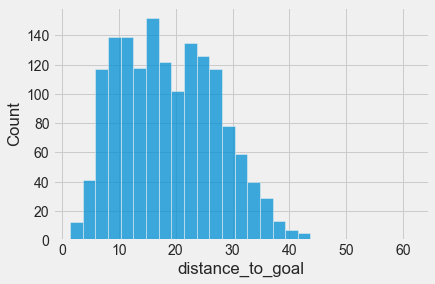

In [22]:
sns.histplot(shots['distance_to_goal'])

<AxesSubplot:xlabel='goal_angle', ylabel='Count'>

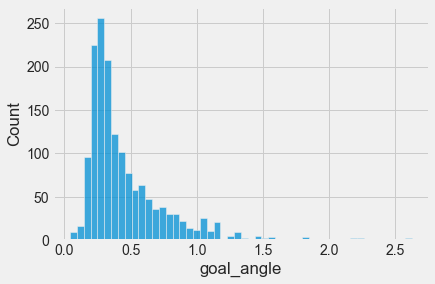

In [23]:
sns.histplot(shots['goal_angle'])

<i>As the two continuous variables to be used in the model, I wanted to look into the distribution of shot distance and angle to goal. Shot distance is roughly normal and as far as I can tell seems fine to use at this point in the model. Goal angle however is certainly skewed right, which makes sense intuitively to me. It's a lot easier for a player to recognize that a sharp angle will be very hard to score from, but that same kind of logic doesn't quite extend to shooting distance since players still feel like they have all or most of the goal to shoot at. Similar to the issue with our imbalance of the target variable, I'd be interested in trying to transform this variable into a normal distribution before modeling. However, like I said I'd like to find a baseline performance to compare to before tweaking and transforming the model too much.</i>

In [14]:
fit = model.fit(X_train, y_train)

In [15]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [16]:
print("The training model score is:" + ' ' + str(model.score(X_train, y_train)))
print("The model score for the test set is: " + str(model.score(X_test, y_test)))

The training model score is: 0.9164370982552801
The model score for the test set is: 0.9186295503211992


<i>These accuracies are surprisingly impressive for such a simple model. Intuitively, most of the work is being done by the shot location, and consequently the distance to goal and goal angles we have calculated. This is very different from my previous work in building xG models as this accuracy is far greater than what I'd been able to achieve previously with similar features like body part/technique. Some factors like technique or body part may be useful, but it's important to point out that most of the work is being done by locations.</i>

In [17]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       428
           1       0.67      0.05      0.10        39

    accuracy                           0.92       467
   macro avg       0.79      0.52      0.53       467
weighted avg       0.90      0.92      0.89       467



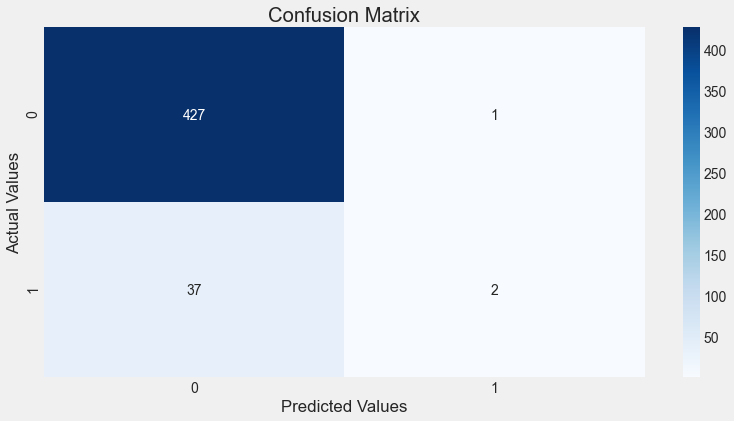

In [18]:
cm = confusion_matrix(y_test,test_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig('confusion_matrix.png')

<u>Conclusion</u>

<i>Now the confusion matrix and classification report here definitely provides some useful insight. You can clearly see that while predicting the test set, the model only predicted 3 total shots as goals out of the 467 shots that were placed into the test set. So while ~92% accuracy looks very good, in this context it's certainly somewhat less impressive. If the model had simply predicted no goal for every single outcome, it would still perform at an accuracy of 91.6488% as opposed to the observed accuracy in the test set of 91.863%. Given that, an accuracy improvement of about .2% is just not very impressive.</i>

<i>As far as further steps on building the model from this point, I have a couple ideas. The first improvement I will look into will likely be normalizing the distance_to_goal and goal_angle features before running the model. In the data and in real life these values are not normally distributed, and the data should be transformed/weighted to reflect that rather than applying linear weights to each one. Intuitively this is bad because the change in value from a shot 5 yards out to 10 yards out is very different than the change in value from shooting 35 yards out instead of 30. Our current model doesn't account for this. Also, I'm only pulling data from the 2018 World Cup since it's contained in one place in StatsBomb's github, but I'd also like to pull all of their openly avaialable event data together into one large dataframe to try to train a more robust and accurate model.</i>

<i>Additionally, there is still more data contained in StatsBomb's event data that I'm not making use of. There are variables to indicate weather or not the shot is a first time shot or not, the ending location of the shot, duration of the event, players around or involved with the event, and id's for related event data such as the key pass leading to the shot. I wanted to keep the model more simple at first with things I knew/strongly suspected to be relevant like body part, shot distance/angle, and technique, but moving forward this additional information provides me with a lot more options. For this current model I'd be very interested in trying to include additional player data to try to capture information about the amount of defensive pressure - maybe using a distance formula from the place of shot and other defenders - as well as experimenting with the first time variable as a feature of the model.</i>

<i>There are two future paths I'd like to take this data beyond this model and this exercise. While this project is more specifically a pre-shot expected goals model (analyzing the likelihood of a goal excluding the quality of the shot itself), it contains enough information that I could build a post-shot expected goals model. This type of model also measures the likelihood of a given shot being score, but by using the duration of the shot and the ending location of the shot you can use it to judge the probability of a goal taking into account the quality of the shot. This also more accurately depicts how likely a goalkeeper would be to save a given chance. And finally using either this model or a future model I would like to run some match simulations. For example, if one team has a significantly greater sum of xG over the course of a game, they would be considered more likely to win a given game. Using packages like random, I could simulate matches thousands of times to determine the probability of an outcome given two teams' shots over the course of a game.</i>